# Part 2

### 1. Explain the distance metric you utilized to calculate the similarity/dissimilarity between small molecules.

I used 1 - (jaccard index) as a distance metric. The jaccard index is the intersect of members divided by the union of members, which gives a measure of similarity between the two groups. Here, for two ligands, the JI is calculated by taking the intersect of their on bits divided by the union. Since this is a measure of similarity between 0 and 1, I do 1 - JI to get a measure of difference or distance.

### 2. Use a dimensionality reduction algorithm (PCA, t-SNE, UMAP, etc) to generate a 2D visualization of the small molecule dataset.

In [1]:
from clusters.algs import *
from scipy.sparse import lil_matrix
import umap
import umap.plot
import matplotlib.pyplot as plt


In [2]:
# Load data (downsampling to the first 2000 ligands)
table = pd.read_csv("./ligand_information.csv")
table['OnBits'] = table['OnBits'].str.split(",")
table = table.head(n = 1000)

# Create a list of lists of onbits for each ligand
lil = list(table['OnBits'])
lil = [list(map(int, i)) for i in lil]

# Create sparse matrix
factor_matrix = lil_matrix((len(table), 1024), dtype=np.float32)
factor_matrix.rows = np.array(lil)
data = [[1] * len(i) for i in lil]
factor_matrix.data = np.array(data)


/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/Users/mtsui1/opt/anaconda3/envs/gen/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [3]:
factor_matrix

<1000x1024 sparse matrix of type '<class 'numpy.float32'>'
	with 16764 stored elements in List of Lists format>

In [4]:
# fit umap
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(factor_matrix)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

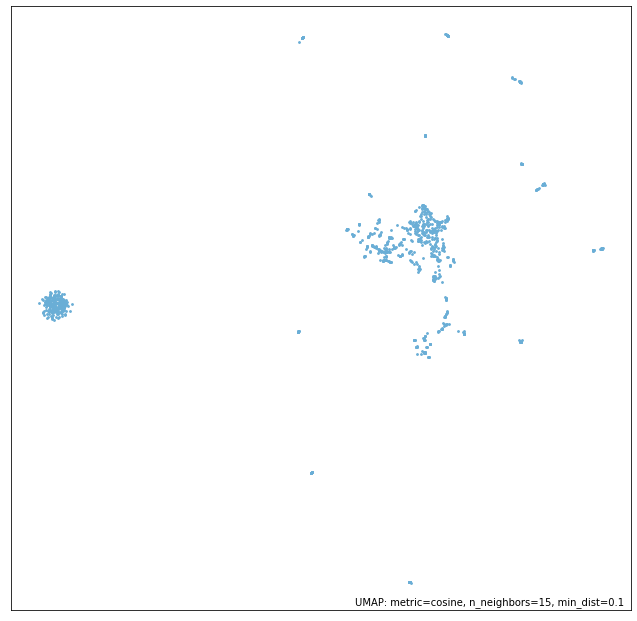

In [5]:
umap.plot.points(mapper)

### 3. Cluster the small molecules using your implementation of a partitioning clustering algorithm. Visualize this clustering by coloring clusters on the 2D visualization generated in question 2.

In [6]:
pc = PartitionClustering()
ligands = pc.get_ligands(len(table))
clusters = {}
sil_scores = []

# Try k = 2,3,4
for i in range(2,5):
    clustering = pc.cluster(ligands, k=i)
    clusters[i] = clustering
    sil_scores.append(pc.silhouette_score(ligands, clustering))

In [7]:
#import json
#with open('./pc_clusters', 'w') as f:
#    json.dump(clusters, f)

In [23]:
import json
with open('./pc_clusters') as f:
    clusters_pc = json.load(f)

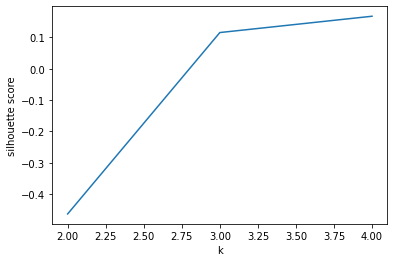

In [25]:
# Plot silhouette scores for k = 2,3,4
# It looks like k = 4 is the best
plt.plot(clusters.keys(), sil_scores)
plt.xlabel("k")
plt.ylabel("silhouette score");

<AxesSubplot:>

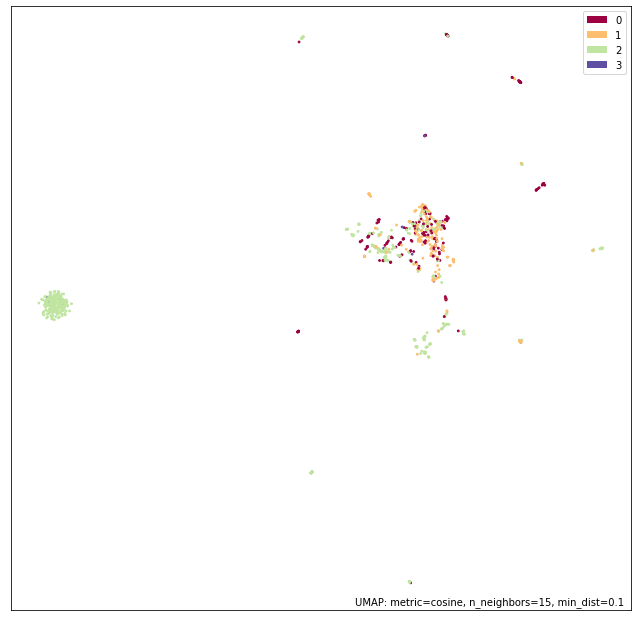

In [9]:
umap.plot.points(mapper, np.array(clusters[4]))

### 4. Explain your choice of partitioning clustering algorithm. Is it sensitive to initialization conditions? How do you select the number of clusters?

In my partition clustering algorithm, the clusters are initialized using the k++ method. It starts by randomly choosing one ligand, then for the rest of the centroids it weights the random choice by distance to the previous centroid. Yes, the final clustering is sensitive to initialization and may vary each time it is run due to the random initialization. I selected k by calculating the mean silhouette scores of a few different values of k. Since UMAP plots reflect local and global relationships between ligands, I also used it as an additional helper. Based on the UMAP plot, it looks like there are at least 2 distinct groups of ligands. Thus, I chose to try k = 2,3,4. Ultimately, k = 4 had the highest silhouette score.


### 5. Cluster the small molecules using your implementation of a hierarchical clustering algorithm. Visualize this clustering in the same way as question 3.

In [10]:
hc = HierarchicalClustering()
ligands = hc.get_ligands(len(table))
clusters_hc = {}
sil_scores_hc = []

# Try k = 2,3,4
for i in range(2,5):
    clustering = hc.cluster(ligands, k=i)
    clusters_hc[i] = clustering
    sil_scores_hc.append(hc.silhouette_score(ligands, clustering))

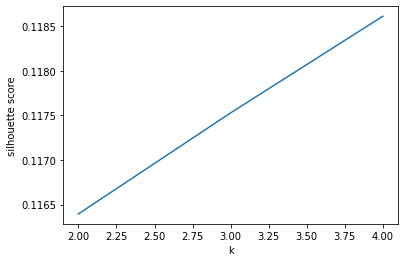

In [11]:
# Plot silhouette scores for k = 2,3,4
# It looks like k = 4 is the best
plt.plot(clusters_hc.keys(), sil_scores_hc)
plt.xlabel("k")
plt.ylabel("silhouette score");

<AxesSubplot:>

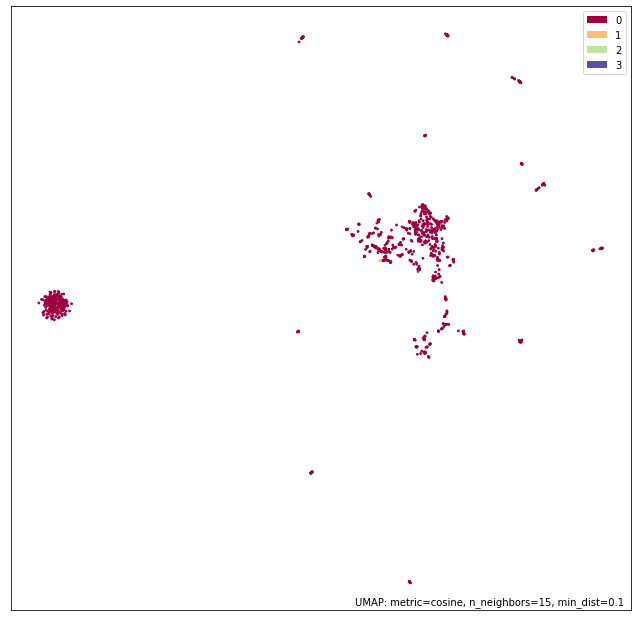

In [12]:
umap.plot.points(mapper, np.array(clusters_hc[4]))

### 6. Explain your choice of hierarchical clustering algorithm. Is it sensitive to initialization conditions? How do you select the number of clusters?

I used single linkage in my HC algorithm, where the distance between two clusters is the minimum distance between their points. This implementation should not be sensitive to initialization because it calculates a distance matrix to group the ligands, which is not random. I selected k in the same way as in partition clustering, by trying a few different values of k and calculating their mean silhouette scores. Here, k=4 also had the highest score.

### 7. Evaluate the quality of both clusterings using your implementation of a clustering quality metric. Explain your choice of quality metric. Which clustering performed ‘best’ according to your metric?

In [28]:
# HC average silhouette
sil_scores_hc[2]

0.11861211309332424

In [29]:
# PC average silhouette
sil_scores[2]

0.1677879642234948

I used average silhouette score to measure clustering quality. The silhouette score of a ligand gives a measure of closeness to ligands in its own cluster vs ligands in the nearest cluster. The higher the score, the bigger the inter-cluster distance is relative to the intra-cluster distance. The average of silhouette scores for all ligands should give a sense of how well separated the ligands are into clusters. Here, PC gave a slightly higher score for k=4.

### 8. Compare the two clusterings using your implementation of clustering similarity. How similar are the two clusterings using this function?

In [31]:
hc.rand_index(clusters[4], clusters_hc[4])

0.40363563563563565

The rand index here shows that the clusterings are not super similar. This definitely makes sense because for some reason my HC is assigning almost every point to one cluster. In my PC, the ligands are more evenly distributed throughout the clusters.

### 9. For the “best” clustering, as determined by your quality metric, visualize the distribution of Autodock Vina scores in each cluster. Do members of the same cluster have similar docking scores? Why or why not?

Sorry, I couldn't get autodock vina to work and ran out of time :(

### 10. Select the top scoring molecule from each cluster. This is your list of cluster heads. Visualize the top 5 by score in PyMOL and pick your favorite. Are they structurally diverse?

In [33]:
table['cluster'] = clusters[4]
table

,LigandID,Score,SMILES,OnBits,cluster
0,0,-1.3,N#C,"[360, 489, 915]",3
1,1,-1.7,O=N,"[53, 623, 650]",1
2,2,-1.7,O=C,"[332, 342, 650]",1
3,4,-2.7,OC#N,"[260, 291, 360, 674, 790, 807]",0
4,5,-2.7,O=N[O-],"[36, 650, 715, 725, 967, 979]",1
...,...,...,...,...,...
995,1002,-4.1,O=C(OC(C)(C)C1CCC(C)CC1)C,"[11, 33, 72, 75, 114, 124, 231, 285, 301, 392,...",1
996,1003,-4.3,C(C)(C)c1cc-2c(C)ccc-2c(C)cc1,"[1, 33, 283, 341, 352, 356, 367, 385, 506, 598...",0
997,1004,-3.7,Nc1c2c([n+H]c3c1CCCC3)cccc2,"[91, 140, 147, 457, 807, 844]",2
998,1005,-4.6,[N+H](=C(\N)/N)\CCN1CCCCCCC1,"[91, 140, 147, 457, 807, 844]",2


In [36]:
# top scoring molecule from each cluster
table.loc[table.groupby('cluster').Score.agg('idxmax')]

,LigandID,Score,SMILES,OnBits,cluster
662,668,-1.2,O=C(OC)/C=C/C#CC#CC#CC,"[31, 33, 49, 81, 128, 132, 200, 351, 413, 418,...",0
1,1,-1.7,O=N,"[53, 623, 650]",1
579,585,-0.8,C=C1C2(C)OC[C@@H](C)C1CCC2,"[4, 29, 33, 35, 36, 138, 192, 250, 264, 285, 3...",2
0,0,-1.3,N#C,"[360, 489, 915]",3


![alt text](./img.png "Title")

They all look very diverse in structure. Some are longer more complex molecules and some are super simple, like O=N.